# Implementation of LeNet-5 CNN from Scratch

This notebook demonstrates an implementation of the LeNet-5 Convolutional Neural Network (CNN) architecture from scratch using NumPy. We'll test the implementation on the MNIST dataset for handwritten digit classification.

## Architecture Overview

LeNet-5 is one of the earliest CNNs and was introduced by Yann LeCun et al. in 1998. Its architecture was designed specifically for handwritten and machine-printed character recognition. The network consists of the following layers:
1. Convolutional Layer (C1)
2. Average Pooling Layer (S2)
3. Convolutional Layer (C3)
4. Average Pooling Layer (S4)
5. Fully Connected Layer (F5)
6. Fully Connected Layer (F6)
7. Output Layer

Let's implement each component and understand how they work.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import time

## Cross Entropy Loss Function

The Cross Entropy Loss is commonly used for classification tasks. For a classification problem with C classes, the cross entropy loss is calculated as:

$L = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ij}\log(\hat{y}_{ij})$

where:
- N is the batch size
- C is the number of classes
- y_{ij} is the true probability of sample i belonging to class j
- \hat{y}_{ij} is the predicted probability of sample i belonging to class j

The gradient of the cross entropy loss with respect to the predicted probabilities is:
$\frac{\partial L}{\partial \hat{y}_{ij}} = -\frac{y_{ij}}{\hat{y}_{ij}}$

In [5]:
class CrossEntropyLoss:
    def forward(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        """
        Compute cross-entropy loss
        
        Args:
            predictions: Network predictions after softmax (batch_size, num_classes)
            targets: One-hot encoded target labels (batch_size, num_classes)
            
        Returns:
            Average loss value across the batch
        """
        epsilon = 1e-15  
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        batch_size = predictions.shape[0]
        return -np.sum(targets * np.log(predictions)) / batch_size
    
    def backward(self, predictions: np.ndarray, targets: np.ndarray) -> np.ndarray:
        """
        Compute gradient of cross-entropy loss with respect to predictions
        
        Args:
            predictions: Network predictions after softmax
            targets: One-hot encoded target labels
            
        Returns:
            Gradient with respect to pre-softmax inputs
        """
        return predictions - targets

## Convolutional Layer

The convolutional layer is the core building block of a CNN. It performs the following operation:

$output[n,k,h,w] = \sum_{c}\sum_{i}\sum_{j} input[n,c,h+i,w+j] \times kernel[k,c,i,j]$

where:
- n is the batch dimension
- c is the input channel dimension
- k is the output channel dimension
- h,w are the spatial dimensions
- kernel is the convolution filter

The backward pass computes two gradients:
1. Gradient with respect to the input
2. Gradient with respect to the kernel weights

Key hyperparameters:
- Kernel size
- Number of filters
- Stride
- Padding

In [8]:
class ConvLayer:
    def __init__(self, num_filters: int, kernel_size: int, input_channels: int = 1, 
                 stride: int = 1, padding: int = 0, learning_rate: float = 0.01):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels
        self.stride = stride
        self.padding = padding
        self.learning_rate = learning_rate
        
        self.weights = np.random.randn(num_filters, input_channels, kernel_size, kernel_size) * \
                      np.sqrt(2.0 / (input_channels * kernel_size * kernel_size))
        self.bias = np.zeros(num_filters)
        
        self.weight_gradients = np.zeros_like(self.weights)
        self.bias_gradients = np.zeros_like(self.bias)
        
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass implementation remains the same"""
        self.input = input_data
        batch_size, channels, height, width = input_data.shape
        
        assert channels == self.input_channels
        
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        
        if self.padding > 0:
            self.padded_input = np.pad(input_data, 
                                     ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
                                     mode='constant')
        else:
            self.padded_input = input_data
            
        output = np.zeros((batch_size, self.num_filters, output_height, output_width))
        
        for i in range(output_height):
            for j in range(output_width):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                
                input_slice = self.padded_input[:, :, h_start:h_end, w_start:w_end]
                for k in range(self.num_filters):
                    output[:, k, i, j] = np.sum(input_slice * self.weights[k], axis=(1,2,3)) + self.bias[k]
        
        return output
    
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Backward pass for convolutional layer
        
        Args:
            gradient: Gradient from the next layer
            
        Returns:
            Gradient with respect to input
        """
        batch_size, _, out_height, out_width = gradient.shape
        _, channels, in_height, in_width = self.input.shape
        
        input_gradient = np.zeros_like(self.input)
        self.weight_gradients = np.zeros_like(self.weights)
        self.bias_gradients = np.zeros_like(self.bias)
        
        self.bias_gradients = np.sum(gradient, axis=(0, 2, 3))
        
        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                
                input_slice = self.padded_input[:, :, h_start:h_end, w_start:w_end]
                
                for k in range(self.num_filters):
                    self.weight_gradients[k] += np.sum(
                        input_slice * gradient[:, k:k+1, i:i+1, j:j+1], axis=0
                    )
                    
                    grad_val = gradient[:, k:k+1, i:i+1, j:j+1]
                    grad_val = grad_val.reshape(batch_size, 1, 1, 1)
                    input_gradient[:, :, h_start:h_end, w_start:w_end] += \
                        self.weights[k].reshape(self.input_channels, self.kernel_size, self.kernel_size) * grad_val
        
        self.weights -= self.learning_rate * self.weight_gradients
        self.bias -= self.learning_rate * self.bias_gradients
        
        return input_gradient

## ReLU (Rectified Linear Unit) Activation

ReLU is a non-linear activation function defined as:

$f(x) = max(0, x)$

Its derivative is simple:
$f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$

ReLU helps introduce non-linearity into the network while being computationally efficient and helping prevent the vanishing gradient problem.

In [11]:
class ReLU:
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        self.input = input_data
        return np.maximum(0, input_data)
    
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Backward pass for ReLU activation
        
        Args:
            gradient: Gradient from the next layer
            
        Returns:
            Gradient with respect to input
        """
        return gradient * (self.input > 0)

## Max Pooling Layer

Max pooling performs down-sampling by dividing the input into rectangular pooling regions and computing the maximum of each region. This helps:
- Reduce spatial dimensions
- Introduce translation invariance
- Reduce computation in deeper layers

The forward pass selects the maximum value in each pooling window:
$output[n,c,h,w] = max_{i,j}(input[n,c,h\cdot s+i,w\cdot s+j])$

where s is the stride of the pooling operation.

During backward pass, gradients flow only through the maximum elements that were selected during the forward pass.

In [14]:
class MaxPoolLayer:
    def __init__(self, pool_size: int = 2, stride: int = 2):
        """
        Initialize max pooling layer
        
        Args:
            pool_size: Size of the pooling window
            stride: Stride for pooling operation
        """
        self.pool_size = pool_size
        self.stride = stride
        
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        self.input = input_data
        batch_size, channels, height, width = input_data.shape
        
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        
        output = np.zeros((batch_size, channels, output_height, output_width))
        self.max_indices = np.zeros_like(output, dtype=np.int32)
        
        for i in range(output_height):
            for j in range(output_width):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                w_start = j * self.stride
                w_end = w_start + self.pool_size
                
                input_slice = input_data[:, :, h_start:h_end, w_start:w_end]
                output[:, :, i, j] = np.max(input_slice, axis=(2, 3))
                
                self.max_indices[:, :, i, j] = np.argmax(input_slice.reshape(batch_size, channels, -1), axis=2)
        
        return output
    
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Backward pass for max pooling layer
        
        Args:
            gradient: Gradient from the next layer
            
        Returns:
            Gradient with respect to input
        """
        batch_size, channels, out_height, out_width = gradient.shape
        _, _, in_height, in_width = self.input.shape
        
        input_gradient = np.zeros_like(self.input)
        
        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                w_start = j * self.stride
                w_end = w_start + self.pool_size
                
                for b in range(batch_size):
                    for c in range(channels):
                        idx = self.max_indices[b, c, i, j]
                        h_idx = idx // self.pool_size
                        w_idx = idx % self.pool_size
                        input_gradient[b, c, h_start + h_idx, w_start + w_idx] = gradient[b, c, i, j]
        
        return input_gradient

In [16]:
def test_backprop():
    batch_size = 2
    input_channels = 1
    input_height = 8
    input_width = 8
    x = np.random.randn(batch_size, input_channels, input_height, input_width)
    
    conv = ConvLayer(num_filters=2, kernel_size=3, input_channels=1)
    relu = ReLU()
    pool = MaxPoolLayer(pool_size=2, stride=2)
    
    conv_out = conv.forward(x)
    relu_out = relu.forward(conv_out)
    pool_out = pool.forward(relu_out)
    
    gradient = np.random.randn(*pool_out.shape)
    
    pool_grad = pool.backward(gradient)
    relu_grad = relu.backward(pool_grad)
    input_grad = conv.backward(relu_grad)
    
    print("Test shapes:")
    print(f"Input: {x.shape}")
    print(f"Conv out: {conv_out.shape}")
    print(f"ReLU out: {relu_out.shape}")
    print(f"Pool out: {pool_out.shape}")
    print(f"Input gradient: {input_grad.shape}")

print("Testing backpropagation:")
test_backprop()

Testing backpropagation:
Test shapes:
Input: (2, 1, 8, 8)
Conv out: (2, 2, 6, 6)
ReLU out: (2, 2, 6, 6)
Pool out: (2, 2, 3, 3)
Input gradient: (2, 1, 8, 8)


In [18]:
import numpy as np
from typing import List, Tuple
import time

def softmax(x: np.ndarray) -> np.ndarray:
    """Compute softmax values for each set of scores in x"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class CrossEntropyLoss:
    def forward(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        batch_size = predictions.shape[0]
        return -np.sum(targets * np.log(predictions)) / batch_size
    
    def backward(self, predictions: np.ndarray, targets: np.ndarray) -> np.ndarray:
        return predictions - targets

class LeNet5:
    def __init__(self, input_shape: Tuple[int, int, int] = (1, 32, 32)):
        channels, height, width = input_shape
        
        self.conv1 = ConvLayer(num_filters=6, kernel_size=5, input_channels=channels, stride=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPoolLayer(pool_size=2, stride=2)
        
        self.conv2 = ConvLayer(num_filters=16, kernel_size=5, input_channels=6, stride=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPoolLayer(pool_size=2, stride=2)
        
        self._calculate_fc_input_size(input_shape)
        
        self.fc1 = FullyConnectedLayer(self.fc_input_size, 120)
        self.relu3 = ReLU()
        
        self.fc2 = FullyConnectedLayer(120, 84)
        self.relu4 = ReLU()
        
        self.fc3 = FullyConnectedLayer(84, 10)
        
    def _calculate_fc_input_size(self, input_shape: Tuple[int, int, int]):
        channels, height, width = input_shape
        
        h = (height - 5 + 1) // 2
        w = (width - 5 + 1) // 2
        
        h = (h - 5 + 1) // 2
        w = (w - 5 + 1) // 2
        
        self.fc_input_size = 16 * h * w
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.layer_outputs = []
        
        x = self.conv1.forward(x)
        self.layer_outputs.append(x)
        x = self.relu1.forward(x)
        self.layer_outputs.append(x)
        x = self.pool1.forward(x)
        self.layer_outputs.append(x)
        
        x = self.conv2.forward(x)
        self.layer_outputs.append(x)
        x = self.relu2.forward(x)
        self.layer_outputs.append(x)
        x = self.pool2.forward(x)
        self.layer_outputs.append(x)
        
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        self.layer_outputs.append(x)
        
        x = self.fc1.forward(x)
        self.layer_outputs.append(x)
        x = self.relu3.forward(x)
        self.layer_outputs.append(x)
        
        x = self.fc2.forward(x)
        self.layer_outputs.append(x)
        x = self.relu4.forward(x)
        self.layer_outputs.append(x)
        
        x = self.fc3.forward(x)
        self.layer_outputs.append(x)
        
        return x
    
    def backward(self, gradient: np.ndarray) -> None:
        gradient = self.fc3.backward(gradient)
        
        gradient = self.relu4.backward(gradient)
        gradient = self.fc2.backward(gradient)
        
        gradient = self.relu3.backward(gradient)
        gradient = self.fc1.backward(gradient)
        
        batch_size = gradient.shape[0]
        last_conv_shape = self.layer_outputs[5].shape  
        gradient = gradient.reshape(last_conv_shape)
        
        gradient = self.pool2.backward(gradient)
        gradient = self.relu2.backward(gradient)
        gradient = self.conv2.backward(gradient)
        
        gradient = self.pool1.backward(gradient)
        gradient = self.relu1.backward(gradient)
        gradient = self.conv1.backward(gradient)
        
import numpy as np
from typing import List, Tuple
import time

class FullyConnectedLayer:
    def __init__(self, input_size: int, output_size: int, learning_rate: float = 0.01):
        """
        Initialize fully connected layer
        
        Args:
            input_size: Number of input features
            output_size: Number of output features
            learning_rate: Learning rate for gradient descent
        """
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.bias = np.zeros(output_size)
        
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass of fully connected layer"""
        self.input = input_data
        if len(input_data.shape) > 2:
            self.input = input_data.reshape(input_data.shape[0], -1)
        return np.dot(self.input, self.weights) + self.bias
    
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Backward pass for fully connected layer
        
        Args:
            gradient: Gradient from next layer
            
        Returns:
            Gradient with respect to input
        """
        input_gradient = np.dot(gradient, self.weights.T)
        if len(self.input.shape) > 2:
            input_gradient = input_gradient.reshape(self.input.shape)
        
        weight_gradients = np.dot(self.input.T, gradient)
        bias_gradients = np.sum(gradient, axis=0)
        
        self.weights -= self.learning_rate * weight_gradients
        self.bias -= self.learning_rate * bias_gradients
        
        return input_gradient

class Trainer:
    def __init__(self, model, learning_rate: float = 0.01):
        """
        Initialize trainer
        
        Args:
            model: Neural network model
            learning_rate: Learning rate for optimization
        """
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = CrossEntropyLoss()
    
    def train_step(self, batch_x: np.ndarray, batch_y: np.ndarray) -> Tuple[float, float]:
        """
        Perform one training step
        
        Args:
            batch_x: Batch of input images
            batch_y: Batch of target labels (one-hot encoded)
            
        Returns:
            Tuple of (loss, accuracy)
        """
        outputs = self.model.forward(batch_x)
        probs = softmax(outputs)
        loss = self.criterion.forward(probs, batch_y)
        
        grad = self.criterion.backward(probs, batch_y)
        self.model.backward(grad)
        
        predictions = np.argmax(probs, axis=1)
        targets = np.argmax(batch_y, axis=1)
        accuracy = np.mean(predictions == targets)
        
        return loss, accuracy
    
    def train_epoch(self, train_x: np.ndarray, train_y: np.ndarray, 
                   batch_size: int = 32) -> Tuple[float, float]:
        """
        Train for one epoch
        
        Args:
            train_x: Training images
            train_y: Training labels (one-hot encoded)
            batch_size: Batch size for training
            
        Returns:
            Tuple of (average loss, average accuracy)
        """
        num_samples = len(train_x)
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_x = train_x[batch_indices]
            batch_y = train_y[batch_indices]
            
            loss, acc = self.train_step(batch_x, batch_y)
            total_loss += loss
            total_acc += acc
            num_batches += 1
        
        return total_loss / num_batches, total_acc / num_batches

def train_model(model, train_x: np.ndarray, train_y: np.ndarray, 
                num_epochs: int = 10, batch_size: int = 32, 
                learning_rate: float = 0.01) -> List[Tuple[float, float]]:
    """
    Train the model
    
    Args:
        model: Neural network model
        train_x: Training images
        train_y: Training labels (one-hot encoded)
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
        learning_rate: Learning rate for optimization
        
    Returns:
        List of (loss, accuracy) tuples for each epoch
    """
    trainer = Trainer(model, learning_rate)
    history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        loss, acc = trainer.train_epoch(train_x, train_y, batch_size)
        end_time = time.time()
        
        history.append((loss, acc))
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Loss: {loss:.4f} - Accuracy: {acc:.4f}")
        print(f"Time: {end_time - start_time:.2f}s")
        print("-" * 30)
    
    return history

def test_training():
    num_samples = 100
    input_channels = 1
    input_height = 32
    input_width = 32
    num_classes = 10
    
    x = np.random.randn(num_samples, input_channels, input_height, input_width)
    y = np.eye(num_classes)[np.random.randint(0, num_classes, num_samples)]
    
    model = LeNet5()
    
    history = train_model(model, x, y, num_epochs=2, batch_size=32, learning_rate=0.01)
    
    print("\nTraining history:")
    for epoch, (loss, acc) in enumerate(history, 1):
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

if __name__ == "__main__":
    test_training()

Epoch 1/2
Loss: 4.9598 - Accuracy: 0.0703
Time: 1.36s
------------------------------
Epoch 2/2
Loss: 2.3041 - Accuracy: 0.0781
Time: 1.36s
------------------------------

Training history:
Epoch 1: Loss = 4.9598, Accuracy = 0.0703
Epoch 2: Loss = 2.3041, Accuracy = 0.0781


## Network Visualization and Analysis

Understanding what the CNN has learned is crucial for debugging and improving the model. We'll visualize:

1. Learned Filters (Kernels)
   - First layer filters typically detect basic features like edges and textures
   - Deeper layer filters combine these to detect more complex patterns

2. Feature Maps
   - Output activations of convolutional layers
   - Shows what patterns each filter responds to

3. Dataset Samples
   - Random samples from the MNIST dataset
   - Helps understand the input distribution

These visualizations help us:
- Verify if the network is learning meaningful features
- Identify potential issues in the learning process
- Understand how the network processes images

In [21]:
def visualize_filters(model, figsize=(15, 5)):
    """
    Visualize learned filters from both convolutional layers
    
    Args:
        model: Trained LeNet-5 model
        figsize: Figure size for the plot
    """
    conv1_weights = model.conv1.weights  
    conv2_weights = model.conv2.weights  
    
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plot_filters_grid(conv1_weights[:, 0, :, :], 'First Convolutional Layer Filters')
    
    plt.subplot(1, 2, 2)
    plot_filters_grid(conv2_weights[:, 0, :, :], 'Second Convolutional Layer Filters (Channel 1)')
    
    plt.tight_layout()
    plt.show()

def plot_filters_grid(filters, title):
    """
    Plot filters in a grid
    
    Args:
        filters: Filter weights to visualize
        title: Title for the subplot
    """
    n_filters = len(filters)
    size = int(np.ceil(np.sqrt(n_filters)))
    
    for i in range(n_filters):
        plt.subplot(size, size, i + 1)
        plt.imshow(filters[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)

def visualize_dataset_samples(x_data, y_data, num_samples=10, figsize=(15, 3)):
    """
    Visualize random samples from the dataset
    
    Args:
        x_data: Image data (shape: (N, 1, 28, 28))
        y_data: Labels (one-hot encoded)
        num_samples: Number of samples to visualize
        figsize: Figure size for the plot
    """
    if len(y_data.shape) > 1:
        labels = np.argmax(y_data, axis=1)
    else:
        labels = y_data
        
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    plt.figure(figsize=figsize)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx, 0], cmap='gray')
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    plt.suptitle('Random Samples from Dataset')
    plt.tight_layout()
    plt.show()

def visualize_feature_maps(model, image, figsize=(15, 5)):
    """
    Visualize feature maps after each convolutional layer
    
    Args:
        model: Trained LeNet-5 model
        image: Single input image (shape: (1, 1, 28, 28))
        figsize: Figure size for the plot
    """
    conv1_out = model.conv1.forward(image)
    relu1_out = model.relu1.forward(conv1_out)
    
    pool1_out = model.pool1.forward(relu1_out)
    conv2_out = model.conv2.forward(pool1_out)
    relu2_out = model.relu2.forward(conv2_out)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plot_feature_maps(relu1_out[0], 'First Layer Feature Maps')
    
    plt.subplot(1, 3, 3)
    plot_feature_maps(relu2_out[0], 'Second Layer Feature Maps')
    
    plt.tight_layout()
    plt.show()

def plot_feature_maps(feature_maps, title):
    """
    Plot feature maps in a grid
    
    Args:
        feature_maps: Feature maps to visualize
        title: Title for the subplot
    """
    n_maps = len(feature_maps)
    size = int(np.ceil(np.sqrt(n_maps)))
    
    for i in range(n_maps):
        plt.subplot(size, size, i + 1)
        plt.imshow(feature_maps[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)

def visualize_model_and_data(model, train_x, train_y):
    """
    Create all visualizations for the model and data
    
    Args:
        model: Trained LeNet-5 model
        train_x: Training images
        train_y: Training labels
    """
    print("Visualizing learned filters...")
    visualize_filters(model)
    
    print("\nVisualizing dataset samples...")
    visualize_dataset_samples(train_x, train_y)
    
    print("\nVisualizing feature maps for a sample image...")
    sample_idx = np.random.randint(len(train_x))
    sample_image = train_x[sample_idx:sample_idx+1]
    visualize_feature_maps(model, sample_image)

## Data Preparation and Loading

### MNIST Dataset
The MNIST dataset consists of:
- 60,000 training images
- 10,000 test images
- 28x28 grayscale images
- 10 classes (digits 0-9)

### Data Processing Steps:
1. Loading and Normalization
   - Images are normalized to [0,1] range by dividing by 255
   - Helps with gradient flow and convergence

2. Reshaping
   - Images are reshaped to (N, 1, 28, 28) format
   - N: batch size
   - 1: number of channels (grayscale)
   - 28x28: image dimensions

3. Label Encoding
   - Labels are one-hot encoded
   - Creates a binary vector of length 10 for each label

In [24]:
import numpy as np
from typing import List, Tuple, Dict
import time
import gzip
import pickle
from urllib.request import urlretrieve
import os

class DataLoader:
    """MNIST data loading and preprocessing"""
    
    @staticmethod
    def load_mnist() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Load MNIST dataset using keras.datasets
        
        Returns:
            Tuple of (train_x, train_y, val_x, val_y)
        """
        try:
            from tensorflow.keras.datasets import mnist
            print("Loading MNIST from tensorflow.keras.datasets...")
            (train_x, train_y), (test_x, test_y) = mnist.load_data()
        except ImportError:
            try:
                from keras.datasets import mnist
                print("Loading MNIST from keras.datasets...")
                (train_x, train_y), (test_x, test_y) = mnist.load_data()
            except ImportError:
                raise ImportError("Please install tensorflow or keras to load MNIST dataset: pip install tensorflow")
        
        train_x = train_x.reshape(-1, 1, 28, 28)
        
        train_x = train_x.astype(np.float32) / 255.0
        test_x = test_x.astype(np.float32) / 255.0
        
        train_y = np.eye(10)[train_y]
        test_y = np.eye(10)[test_y]
        
        val_size = 5000
        val_x = train_x[-val_size:]
        val_y = train_y[-val_size:]
        train_x = train_x[:-val_size]
        train_y = train_y[:-val_size]
        
        return train_x, train_y, val_x, val_y

In [26]:
class LearningRateScheduler:
    """Learning rate scheduling with decay"""
    
    def __init__(self, initial_lr: float = 0.01, decay_factor: float = 0.5, 
                 patience: int = 3, min_lr: float = 1e-5):
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor
        self.patience = patience
        self.min_lr = min_lr
        self.current_lr = initial_lr
        self.wait = 0
        self.best_loss = float('inf')
    
    def update(self, val_loss: float) -> float:
        """
        Update learning rate based on validation loss
        
        Args:
            val_loss: Current validation loss
            
        Returns:
            New learning rate
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.current_lr = max(self.current_lr * self.decay_factor, self.min_lr)
            self.wait = 0
            
        return self.current_lr

class ModelCheckpoint:
    """Save best model weights based on validation performance"""
    
    def __init__(self, filepath: str = 'best_model.pkl'):
        self.filepath = filepath
        self.best_loss = float('inf')
    
    def update(self, model: 'LeNet5', val_loss: float) -> bool:
        """
        Update model checkpoint if validation loss improves
        
        Args:
            model: Current model
            val_loss: Current validation loss
            
        Returns:
            True if model was saved, False otherwise
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            with open(self.filepath, 'wb') as f:
                pickle.dump({
                    'conv1': {'weights': model.conv1.weights, 'bias': model.conv1.bias},
                    'conv2': {'weights': model.conv2.weights, 'bias': model.conv2.bias},
                    'fc1': {'weights': model.fc1.weights, 'bias': model.fc1.bias},
                    'fc2': {'weights': model.fc2.weights, 'bias': model.fc2.bias},
                    'fc3': {'weights': model.fc3.weights, 'bias': model.fc3.bias}
                }, f)
            return True
        return False

class EarlyStopping:
    """Stop training when validation loss stops improving"""
    
    def __init__(self, patience: int = 10, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.should_stop = False
    
    def update(self, val_loss: float) -> bool:
        """
        Update early stopping state
        
        Args:
            val_loss: Current validation loss
            
        Returns:
            True if training should stop, False otherwise
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
        
        return self.should_stop

In [28]:
class Trainer:
    def __init__(self, model, learning_rate: float = 0.01):
        self.model = model
        self.lr_scheduler = LearningRateScheduler(initial_lr=learning_rate)
        self.checkpoint = ModelCheckpoint()
        self.early_stopping = EarlyStopping()
        self.criterion = CrossEntropyLoss()
        
        for layer in [model.conv1, model.conv2, model.fc1, model.fc2, model.fc3]:
            layer.learning_rate = learning_rate
    
    def evaluate(self, val_x: np.ndarray, val_y: np.ndarray, batch_size: int = 32) -> Tuple[float, float]:
        """Evaluate model on validation data"""
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for start_idx in range(0, len(val_x), batch_size):
            end_idx = min(start_idx + batch_size, len(val_x))
            batch_x = val_x[start_idx:end_idx]
            batch_y = val_y[start_idx:end_idx]
            
            outputs = self.model.forward(batch_x)
            probs = softmax(outputs)
            loss = self.criterion.forward(probs, batch_y)
            
            predictions = np.argmax(probs, axis=1)
            targets = np.argmax(batch_y, axis=1)
            accuracy = np.mean(predictions == targets)
            
            total_loss += loss
            total_acc += accuracy
            num_batches += 1
        
        return total_loss / num_batches, total_acc / num_batches
    
    def train_epoch(self, train_x: np.ndarray, train_y: np.ndarray, 
                   val_x: np.ndarray, val_y: np.ndarray,
                   batch_size: int = 32) -> Dict[str, float]:
        """Train for one epoch and return metrics"""
        num_samples = len(train_x)
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_x = train_x[batch_indices]
            batch_y = train_y[batch_indices]
            
            outputs = self.model.forward(batch_x)
            probs = softmax(outputs)
            loss = self.criterion.forward(probs, batch_y)
            
            grad = self.criterion.backward(probs, batch_y)
            self.model.backward(grad)
            
            predictions = np.argmax(probs, axis=1)
            targets = np.argmax(batch_y, axis=1)
            accuracy = np.mean(predictions == targets)
            
            total_loss += loss
            total_acc += accuracy
            num_batches += 1
        
        val_loss, val_acc = self.evaluate(val_x, val_y, batch_size)
        
        new_lr = self.lr_scheduler.update(val_loss)
        for layer in [self.model.conv1, self.model.conv2, 
                     self.model.fc1, self.model.fc2, self.model.fc3]:
            layer.learning_rate = new_lr
        
        self.checkpoint.update(self.model, val_loss)
        
        return {
            'train_loss': total_loss / num_batches,
            'train_acc': total_acc / num_batches,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'learning_rate': new_lr
        }

## Training Process

The training process involves:

1. Forward Pass:
   - Data flows through the network layers
   - Loss is computed using cross entropy
   
2. Backward Pass:
   - Gradients are computed using backpropagation
   - Parameters are updated using gradient descent
   
3. Optimization:
   - Learning rate scheduling
   - Early stopping
   - Model checkpointing

We use mini-batch gradient descent with a batch size of 32 and initial learning rate of 0.01.

In [31]:
def train_model(model, train_x: np.ndarray, train_y: np.ndarray,
                val_x: np.ndarray, val_y: np.ndarray,
                num_epochs: int = 50, batch_size: int = 32,
                learning_rate: float = 0.01) -> List[Dict[str, float]]:
    """Train the model and return training history"""
    trainer = Trainer(model, learning_rate)
    history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        metrics = trainer.train_epoch(train_x, train_y, val_x, val_y, batch_size)
        end_time = time.time()
        
        history.append(metrics)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {metrics['train_loss']:.4f} - Train Acc: {metrics['train_acc']:.4f}")
        print(f"Val Loss: {metrics['val_loss']:.4f} - Val Acc: {metrics['val_acc']:.4f}")
        print(f"Learning Rate: {metrics['learning_rate']:.6f}")
        print(f"Time: {end_time - start_time:.2f}s")
        
        if trainer.early_stopping.update(metrics['val_loss']):
            print("\nEarly stopping triggered!")
            break
    
    return history

Loading MNIST dataset...


2024-12-27 20:30:19.068733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735342219.084862 2283499 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735342219.089565 2283499 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 20:30:19.105730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading MNIST from tensorflow.keras.datasets...
Training samples: 55000
Validation samples: 5000

Starting training...

Epoch 1/50
Train Loss: 0.2394 - Train Acc: 0.9256
Val Loss: 0.0760 - Val Acc: 0.9797
Learning Rate: 0.010000
Time: 501.66s

Epoch 2/50
Train Loss: 0.0836 - Train Acc: 0.9756
Val Loss: 0.0718 - Val Acc: 0.9775
Learning Rate: 0.010000
Time: 500.73s

Epoch 3/50
Train Loss: 0.0617 - Train Acc: 0.9820
Val Loss: 0.0604 - Val Acc: 0.9823
Learning Rate: 0.010000
Time: 499.55s

Epoch 4/50
Train Loss: 0.0526 - Train Acc: 0.9840
Val Loss: 0.0846 - Val Acc: 0.9763
Learning Rate: 0.010000
Time: 499.77s

Epoch 5/50
Train Loss: 0.0457 - Train Acc: 0.9867
Val Loss: 0.0521 - Val Acc: 0.9851
Learning Rate: 0.010000
Time: 498.77s

Epoch 6/50
Train Loss: 0.0507 - Train Acc: 0.9854
Val Loss: 0.0613 - Val Acc: 0.9837
Learning Rate: 0.010000
Time: 497.92s

Epoch 7/50
Train Loss: 0.0363 - Train Acc: 0.9894
Val Loss: 0.0651 - Val Acc: 0.9851
Learning Rate: 0.010000
Time: 500.14s

Epoch 8/50
T

/tmp/ipykernel_2283499/1317510657.py:20: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


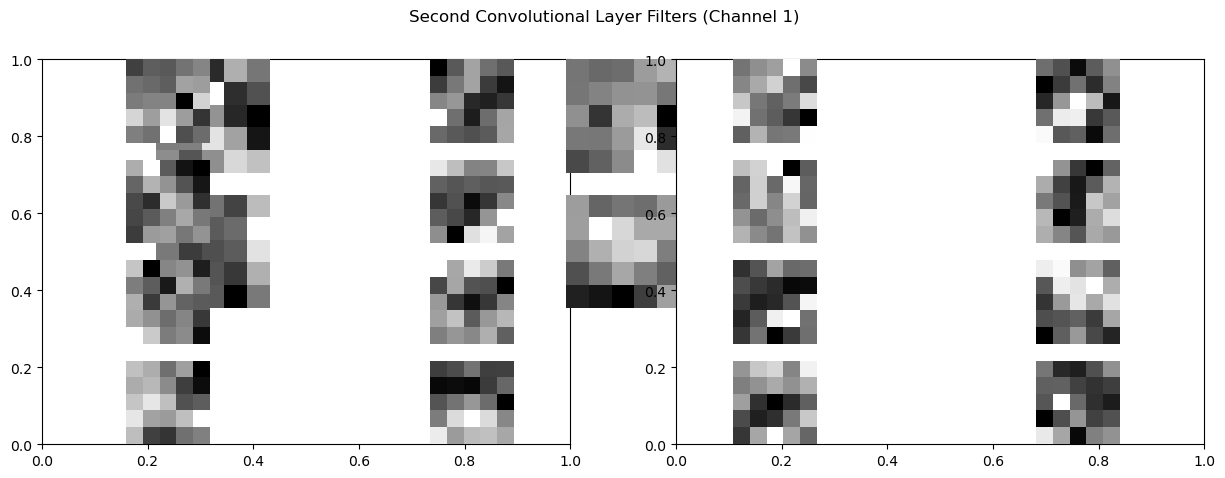


Visualizing dataset samples...


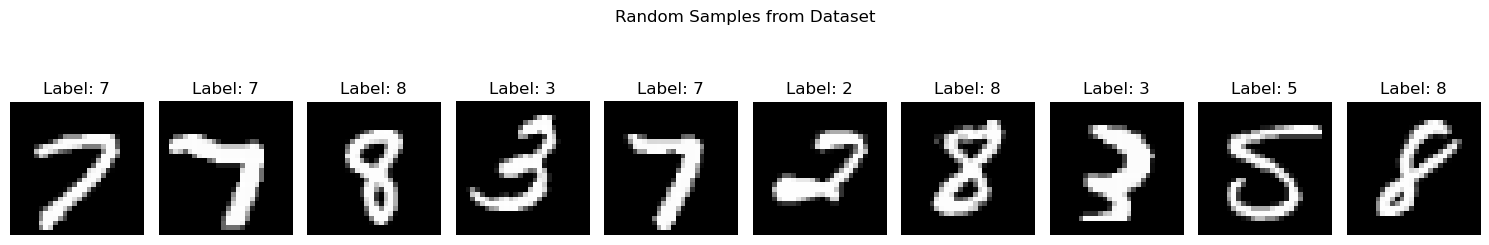


Visualizing feature maps for a sample image...


/tmp/ipykernel_2283499/1317510657.py:96: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


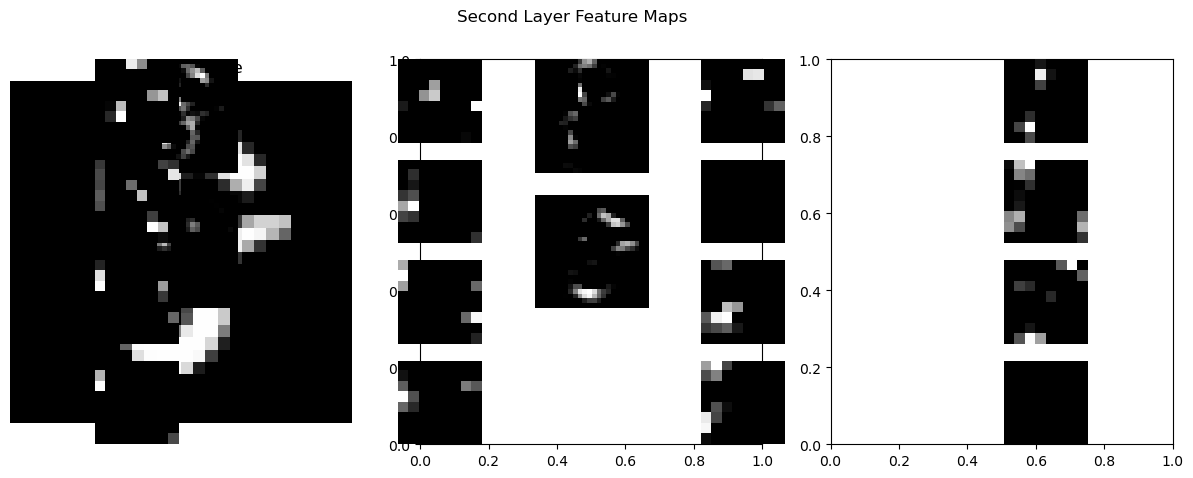

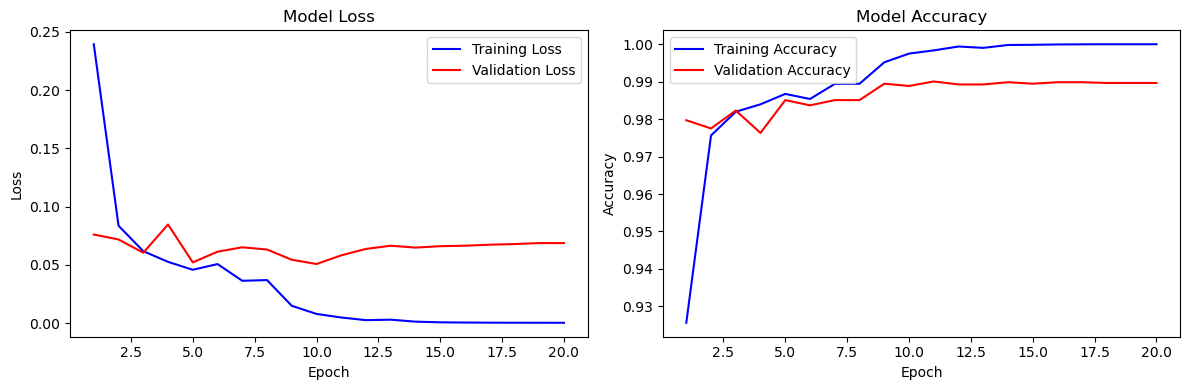

In [33]:
def main():
    print("Loading MNIST dataset...")
    train_x, train_y, val_x, val_y = DataLoader.load_mnist()
    print(f"Training samples: {len(train_x)}")
    print(f"Validation samples: {len(val_x)}")
    
    model = LeNet5(input_shape=(1, 28, 28))
    
    print("\nStarting training...")
    history = train_model(model, train_x, train_y, val_x, val_y,
                         num_epochs=50, batch_size=32, learning_rate=0.01)
    
    print("\nGenerating visualizations...")
    visualize_model_and_data(model, train_x, train_y)
    
    epochs = range(1, len(history) + 1)
        
    plt.figure(figsize=(12, 4))
        
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [m['train_loss'] for m in history], 'b-', label='Training Loss')
    plt.plot(epochs, [m['val_loss'] for m in history], 'r-', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [m['train_acc'] for m in history], 'b-', label='Training Accuracy')
    plt.plot(epochs, [m['val_acc'] for m in history], 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
        
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()